##### Copyright 2020 Google LLC.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a href="https://colab.research.google.com/github/google-research/big_transfer/blob/master/colabs/big_transfer_jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BigTransfer (BiT): A step-by-step tutorial for state-of-the-art vision

This colab demonstrates how to:
1. Load BiT models in JAX.
2. Make predictions using BiT pre-trained on CIFAR-10.
3. Fine-tune BiT on 5-shot CIFAR-100 and get amazing results!

It is good to get an understanding or quickly try things. However, to run longer training runs, we recommend using the commandline scripts at http://github.com/google-research/big_transfer

# Install flax and run imports

In [1]:
#@markdown Select whether you would like to store data in your personal drive.
#@markdown
#@markdown If you select **yes**, you will need to authorize Colab to access
#@markdown your personal drive
#@markdown
#@markdown If you select **no**, then any changes you make will diappear when
#@markdown this Colab's VM restarts after some time of inactivity...
use_gdrive = 'yes'  #@param ["yes", "no"]

if use_gdrive == 'yes':
  from google.colab import drive
  drive.mount('/gdrive')
  root = '/gdrive/My Drive/Fall 20-21/COS 454/Project/cnn_txf_bias/big_transfer'
  import os
  if not os.path.isdir(root):
    os.mkdir(root)
  os.chdir(root)
  print(f'\nChanged CWD to "{root}"')
else:
  from IPython import display
  display.display(display.HTML(
      '<h1 style="color:red">CHANGES NOT PERSISTED</h1>'))

Mounted at /gdrive

Changed CWD to "/gdrive/My Drive/Fall 20-21/COS 454/Project/cnn_txf_bias/big_transfer"


In [2]:
!pip install flax
!pip install tfa-nightly
!pip install tensorflow_io

     |████████████████████████████████| 163kB 8.1MB/s 
     |████████████████████████████████| 706kB 8.5MB/s 
     |████████████████████████████████| 25.3MB 135kB/s 


In [3]:
import io
import re

from functools import partial

import numpy as np

import matplotlib.pyplot as plt
import random

import jax
import jax.numpy as jnp

import flax
import flax.nn as nn
import flax.optim as optim
import flax.jax_utils as flax_utils

# Assert that GPU is available
assert 'Gpu' in str(jax.devices())

import tensorflow as tf
import tensorflow_datasets as tfds

# Architecture and function for transforming BiT weights to JAX to format

In [4]:
def fixed_padding(x, kernel_size):
  pad_total = kernel_size - 1
  pad_beg = pad_total // 2
  pad_end = pad_total - pad_beg

  x = jax.lax.pad(x, 0.0,
                  ((0, 0, 0),
                   (pad_beg, pad_end, 0), (pad_beg, pad_end, 0),
                   (0, 0, 0)))
  return x


def standardize(x, axis, eps):
  x = x - jnp.mean(x, axis=axis, keepdims=True)
  x = x / jnp.sqrt(jnp.mean(jnp.square(x), axis=axis, keepdims=True) + eps)
  return x


class GroupNorm(nn.Module):
  """Group normalization (arxiv.org/abs/1803.08494)."""

  def apply(self, x, num_groups=32):

    input_shape = x.shape
    group_shape = x.shape[:-1] + (num_groups, x.shape[-1] // num_groups)

    x = x.reshape(group_shape)

    # Standardize along spatial and group dimensions
    x = standardize(x, axis=[1, 2, 4], eps=1e-5)
    x = x.reshape(input_shape)

    bias_scale_shape = tuple([1, 1, 1] + [input_shape[-1]])
    x = x * self.param('scale', bias_scale_shape, nn.initializers.ones)
    x = x + self.param('bias', bias_scale_shape, nn.initializers.zeros)
    return x


class StdConv(nn.Conv):

  def param(self, name, shape, initializer):
    param = super().param(name, shape, initializer)
    if name == 'kernel':
      param = standardize(param, axis=[0, 1, 2], eps=1e-10)
    return param


class RootBlock(nn.Module):

  def apply(self, x, width):
    x = fixed_padding(x, 7)
    x = StdConv(x, width, (7, 7), (2, 2),
                padding="VALID",
                bias=False,
                name="conv_root")

    x = fixed_padding(x, 3)
    x = nn.max_pool(x, (3, 3), strides=(2, 2), padding="VALID")

    return x


class ResidualUnit(nn.Module):
  """Bottleneck ResNet block."""

  def apply(self, x, nout, strides=(1, 1)):
    x_shortcut = x
    needs_projection = x.shape[-1] != nout * 4 or strides != (1, 1)

    group_norm = GroupNorm
    conv = StdConv.partial(bias=False)

    x = group_norm(x, name="gn1")
    x = nn.relu(x)
    if needs_projection:
      x_shortcut = conv(x, nout * 4, (1, 1), strides, name="conv_proj")
    x = conv(x, nout, (1, 1), name="conv1")

    x = group_norm(x, name="gn2")
    x = nn.relu(x)
    x = fixed_padding(x, 3)
    x = conv(x, nout, (3, 3), strides, name="conv2", padding='VALID')

    x = group_norm(x, name="gn3")
    x = nn.relu(x)
    x = conv(x, nout * 4, (1, 1), name="conv3")

    return x + x_shortcut


class ResidualBlock(nn.Module):

  def apply(self, x, block_size, nout, first_stride):
    x = ResidualUnit(
        x, nout, strides=first_stride,
        name="unit01")
    for i in range(1, block_size):
      x = ResidualUnit(
          x, nout, strides=(1, 1),
          name=f"unit{i+1:02d}")
    return x


class ResNet(nn.Module):
  """ResNetV2."""

  def apply(self, x, num_classes=1000,
            width_factor=1, num_layers=50):
    block_sizes = _block_sizes[num_layers]

    width = 64 * width_factor

    root_block = RootBlock.partial(width=width)
    x = root_block(x, name='root_block')

    # Blocks
    for i, block_size in enumerate(block_sizes):
      x = ResidualBlock(x, block_size, width * 2 ** i,
                        first_stride=(1, 1) if i == 0 else (2, 2),
                        name=f"block{i + 1}")

    # Pre-head
    x = GroupNorm(x, name='norm-pre-head')
    x = nn.relu(x)
    x = jnp.mean(x, axis=(1, 2))

    # Head
    x = nn.Dense(x, num_classes, name="conv_head",
                 kernel_init=nn.initializers.zeros)

    return x.astype(jnp.float32)


_block_sizes = {
      50: [3, 4, 6, 3],
      101: [3, 4, 23, 3],
      152: [3, 8, 36, 3],
  }


def transform_params(params, params_tf, num_classes, init_head=False):
  # BiT and JAX models have different naming conventions, so we need to
  # properly map TF weights to JAX weights
  params['root_block']['conv_root']['kernel'] = (
    params_tf['resnet/root_block/standardized_conv2d/kernel'])

  for block in ['block1', 'block2', 'block3', 'block4']:
    units = set([re.findall(r'unit\d+', p)[0] for p in params_tf.keys()
                 if p.find(block) >= 0])
    for unit in units:
      for i, group in enumerate(['a', 'b', 'c']):
        params[block][unit][f'conv{i+1}']['kernel'] = (
          params_tf[f'resnet/{block}/{unit}/{group}/'
                    'standardized_conv2d/kernel'])
        params[block][unit][f'gn{i+1}']['bias'] = (
          params_tf[f'resnet/{block}/{unit}/{group}/'
                    'group_norm/beta'][None, None, None])
        params[block][unit][f'gn{i+1}']['scale'] = (
          params_tf[f'resnet/{block}/{unit}/{group}/'
                    'group_norm/gamma'][None, None, None])

      projs = [p for p in params_tf.keys()
               if p.find(f'{block}/{unit}/a/proj') >= 0]
      assert len(projs) <= 1
      if projs:
        params[block][unit]['conv_proj']['kernel'] = params_tf[projs[0]]

  params['norm-pre-head']['bias'] = (
    params_tf['resnet/group_norm/beta'][None, None, None])
  params['norm-pre-head']['scale'] = (
    params_tf['resnet/group_norm/gamma'][None, None, None])

  if init_head:
    params['conv_head']['kernel'] = params_tf['resnet/head/conv2d/kernel'][0, 0]
    params['conv_head']['bias'] = params_tf['resnet/head/conv2d/bias']
  else:
    params['conv_head']['kernel'] = np.zeros(
      (params['conv_head']['kernel'].shape[0], num_classes), dtype=np.float32)
    params['conv_head']['bias'] = np.zeros(num_classes, dtype=np.float32)

# Run BiT-M-ResNet50x1 already fine-tuned on CIFAR-10

## Build model and load weights

In [5]:
with tf.io.gfile.GFile('gs://bit_models/BiT-M-R50x1-CIFAR10.npz', 'rb') as f:
  params_tf = np.load(f)
params_tf = dict(zip(params_tf.keys(), params_tf.values()))

for k in params_tf:
  params_tf[k] = jnp.array(params_tf[k])

ResNet_cifar10 = ResNet.partial(num_classes=10)

def resnet_fn(params, images):
  return ResNet_cifar10.partial(num_classes=10).call(params, images)

resnet_init = ResNet_cifar10.init_by_shape
_, params = resnet_init(jax.random.PRNGKey(0), [([1, 224, 224, 3], jnp.float32)])

transform_params(params, params_tf, 10, init_head=True)

## Prepare data

In [6]:
data_builder = tfds.builder('cifar10')
data_builder.download_and_prepare()

def _pp(data):
  im = data['image']
  im = tf.image.resize(im, [128, 128])
  im = (im - 127.5) / 127.5
  data['image'] = im
  return {'image': data['image'], 'label': data['label']}

data = data_builder.as_dataset(split='test')
data = data.map(_pp)
data = data.batch(100)
data_iter = data.as_numpy_iterator()

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompletePIT7V1/cifar10-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompletePIT7V1/cifar10-test.tfrecord


Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


## Run BiT

In [7]:
correct, n = 0, 0
for batch in data_iter:
  preds = resnet_fn(params, batch['image'])
  correct += np.sum(np.argmax(preds, axis=1) == batch['label'])
  n += len(preds)

print(f"CIFAR-10 accuracy of BiT-M-R50x1: {correct / n:0.3%}")

CIFAR-10 accuracy of BiT-M-R50x1: 97.640%


# Run finetuning on CIFAR-10

## Prepare data

In [8]:
data_builder = tfds.builder('cifar10')
data_builder.download_and_prepare()

def get_data(split, repeats, batch_size, images_per_class, shuffle_buffer):
  data = data_builder.as_dataset(split=split)

  if split == 'train':
    data = data.batch(50000)

    data = data.as_numpy_iterator().next()

    # np.random.seed(0)
    # indices = [idx 
    #           for cls in range(10)
    #           for idx in np.random.choice(np.where(data['label'] == cls)[0],
    #                                       images_per_class,
    #                                       replace=False)]

    # data = {'image': data['image'][indices],
    #         'label': data['label'][indices]}

    data = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(data['image']),
                                tf.data.Dataset.from_tensor_slices(data['label'])))
    data = data.map(lambda x, y: {'image': x, 'label': y})
  else:
    data = data.map(lambda d: {'image': d['image'], 'label': d['label']})

  def _pp(data):
    im = data['image']
    if split == 'train':
      im = tf.image.resize(im, [160, 160])
      im = tf.image.random_crop(im, [128, 128, 3])
      im = tf.image.flip_left_right(im)
    else:
      im = tf.image.resize(im, [128, 128])
    im = (im - 127.5) / 127.5
    data['image'] = im
    data['label'] = tf.one_hot(data['label'], 10)
    return {'image': data['image'], 'label': data['label']}

  data = data.repeat(repeats)
  data = data.shuffle(shuffle_buffer)
  data = data.map(_pp)
  return data.batch(batch_size)

data_train = get_data(split='train', repeats=None, images_per_class=5000,
                      batch_size=256, shuffle_buffer=500)
data_test = get_data(split='test', repeats=1, images_per_class=None,
                      batch_size=250, shuffle_buffer=1)

## Build model and load weights

In [13]:
@jax.jit
def resnet_fn(params, images):
  return ResNet.partial(num_classes=10).call(params, images)

def cross_entropy_loss(*, logits, labels):
  logp = jax.nn.log_softmax(logits)
  return -jnp.mean(jnp.sum(logp * labels, axis=1))

def loss_fn(params, images, labels):
  logits = resnet_fn(params, images)
  return cross_entropy_loss(logits=logits, labels=labels)

@jax.jit
def update_fn(opt, lr, images, labels):
  l, g = jax.value_and_grad(loss_fn)(opt.target, images, labels)
  opt = opt.apply_gradient(g, learning_rate=lr)
  return opt, l

with tf.io.gfile.GFile('gs://bit_models/BiT-M-R50x1-ILSVRC2012.npz', 'rb') as f:
  params_tf = np.load(f)
params_tf = dict(zip(params_tf.keys(), params_tf.values()))

resnet_init = ResNet.partial(num_classes=10).init_by_shape
_, params = resnet_init(jax.random.PRNGKey(0), [([1, 224, 224, 3], jnp.float32)])
transform_params(params, params_tf, 10, init_head=False)

## Run optimization

In [10]:
def get_lr(step):
  lr = 0.03
  if step < 100:
    return lr * (step / 100)
  else:
    for s in range(200, 1000, 100):
      if s < step:
        lr /= 10
    return lr

Running Experiment: Baseline
Step: 1000, Test accuracy: 93.210%
Generating confusion matrix for: Baseline
Running SIN Test
 100.00%
Running Experiment: Rotate
Step: 2000, Test accuracy: 84.310%
Running Experiment: Cutout
Step: 3000, Test accuracy: 94.100%
Running Experiment: Sobel Filtering
Step: 4000, Test accuracy: 88.980%
Running Experiment: Gaussian Blur
Step: 5000, Test accuracy: 87.390%
Running Experiment: Color Distortion
Step: 6000, Test accuracy: 91.160%
Running Experiment: Gaussain Noise
Step: 7000, Test accuracy: 92.120%
Generating confusion matrix for: Fine-tuned
Running SIN Test
 100.00%


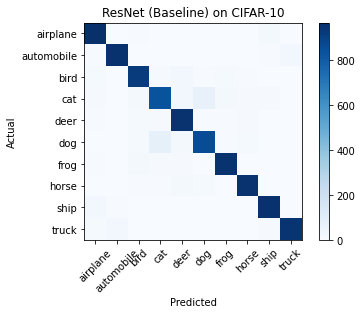

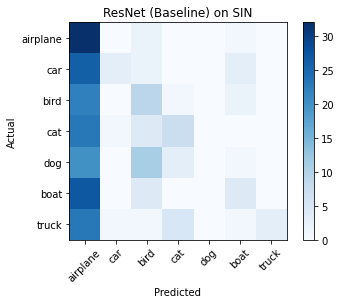

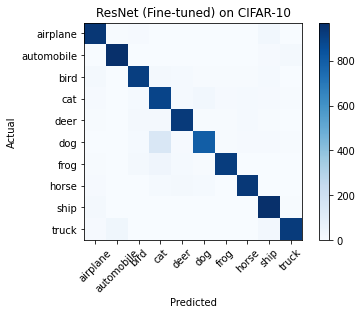

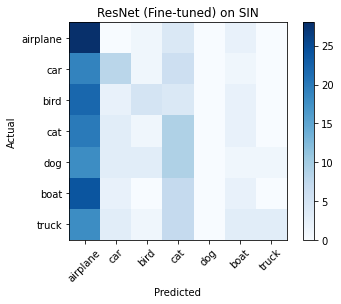

In [17]:
import cv2
import csv
import re
import os
import sys
import tensorflow_addons as tfa
from sklearn.metrics import confusion_matrix

if '../vision_transformer' not in sys.path:
  sys.path.append('../vision_transformer')

# Adding simclr directory to path
if '../simclr' not in sys.path:
  sys.path.append('../simclr')

# Importing data-augmentation functions
import data_util

from vit_jax import checkpoint
import tensorflow_io as tfio
import tensorflow as tf

labelnames = dict(
  # https://www.cs.toronto.edu/~kriz/cifar.html
  cifar10=('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'),
  # https://www.cs.toronto.edu/~kriz/cifar.html
  cifar100=('apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'computer_keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm')
)
dataset='cifar10'
base = 'Baseline'
ft = 'Fine-tuned'

model = 'BiT-M-R50x1'

opt = optim.Momentum(beta=0.9).create(params)

tf.compat.v1.enable_eager_execution()
# tf.compat.v1.disable_eager_execution

experiments = ['Baseline', 'Rotate', 'Cutout', 'Sobel Filtering', 'Gaussian Blur', 'Color Distortion', 'Gaussain Noise']

categories_cifar10 = ['airplane', 'automobile', 'bird', 'cat', 'dog', 'ship', 'truck']
categories_SIN = ['airplane', 'car', 'bird', 'cat', 'dog', 'boat', 'truck']


# Calculating total images in SIN-subset
total_images = 0
for c in categories_SIN:
  for im in os.listdir("./stimuli/cue-conflict/" + c):

    shape_label = c
    texture_label = re.search('-(.*).png', im).group(1)[:-1]

    if texture_label not in categories_SIN: continue

    total_images += 1

for exp in range(0, len(experiments)):
  print(f'Running Experiment: {experiments[exp]}')
  
  predicted_array = []
  true_array = []

  if exp == 0:
    # Training loop
    for step, batch in zip(range(1000), data_train.as_numpy_iterator()):
      opt, loss_value = update_fn(
            opt, get_lr(step), batch["image"], batch["label"])
      if opt.state.step % 100 == 0:
        acc = np.mean([c for test_batch in data_test.as_numpy_iterator()
                      for c in (np.argmax(test_batch['label'], axis=1) ==
                                np.argmax(resnet_fn(opt.target, test_batch['image']), axis=1))])
        print(f"\rStep: {opt.state.step}, Test accuracy: {acc:0.3%}", end="")

  if exp == 1:
    # Training loop
    for step, batch in zip(range(1000), data_train.as_numpy_iterator()):
      images, labels = batch['image'], batch['label']
      bi = tf.image.rot90(images, random.randint(1, 3))
      images = bi.numpy()
      batch_new = {'image': images, 'label': labels}
      opt, loss_value = update_fn(
            opt, get_lr(step), batch_new["image"], batch_new["label"])
      if opt.state.step % 100 == 0:
        acc = np.mean([c for test_batch in data_test.as_numpy_iterator()
                      for c in (np.argmax(test_batch['label'], axis=1) ==
                                np.argmax(resnet_fn(opt.target, test_batch['image']), axis=1))])
        print(f"\rStep: {opt.state.step}, Test accuracy: {acc:0.3%}", end="")

  if exp == 2:
    # Training loop
    for step, batch in zip(range(1000), data_train.as_numpy_iterator()):
      images, labels = batch['image'], batch['label']
      bi = tfa.image.random_cutout(images, tuple([np.int32(random.randrange(2, 64, 2)), np.int32(random.randrange(2, 64, 2))]))
      images = bi.numpy()
      batch_new = {'image': images, 'label': labels}
      opt, loss_value = update_fn(
            opt, get_lr(step), batch_new["image"], batch_new["label"])
      if opt.state.step % 100 == 0:
        acc = np.mean([c for test_batch in data_test.as_numpy_iterator()
                      for c in (np.argmax(test_batch['label'], axis=1) ==
                                np.argmax(resnet_fn(opt.target, test_batch['image']), axis=1))])
        print(f"\rStep: {opt.state.step}, Test accuracy: {acc:0.3%}", end="")

  if exp == 3:
    # Training loop
    for step, batch in zip(range(1000), data_train.as_numpy_iterator()):
      images, labels = batch['image'], batch['label']
      bi = tfio.experimental.filter.sobel(images)
      images = bi.numpy()
      batch_new = {'image': images, 'label': labels}
      opt, loss_value = update_fn(
            opt, get_lr(step), batch_new["image"], batch_new["label"])
      if opt.state.step % 100 == 0:
        acc = np.mean([c for test_batch in data_test.as_numpy_iterator()
                      for c in (np.argmax(test_batch['label'], axis=1) ==
                                np.argmax(resnet_fn(opt.target, test_batch['image']), axis=1))])
        print(f"\rStep: {opt.state.step}, Test accuracy: {acc:0.3%}", end="")
  
  if exp == 4:
    # Training loop
    for step, batch in zip(range(1000), data_train.as_numpy_iterator()):
      images, labels = batch['image'], batch['label']
      bi = tfa.image.gaussian_filter2d(images) #, filter_shape = [30, 30], sigma = 5)
      images = bi.numpy()
      opt, loss_value = update_fn(
            opt, get_lr(step), batch_new["image"], batch_new["label"])
      if opt.state.step % 100 == 0:
        acc = np.mean([c for test_batch in data_test.as_numpy_iterator()
                      for c in (np.argmax(test_batch['label'], axis=1) ==
                                np.argmax(resnet_fn(opt.target, test_batch['image']), axis=1))])
        print(f"\rStep: {opt.state.step}, Test accuracy: {acc:0.3%}", end="")

  if exp == 5:
    # Training loop
    for step, batch in zip(range(1000), data_train.as_numpy_iterator()):
      images, labels = batch['image'], batch['label']
      for i in range(images.shape[0]):
        bi = data_util.color_jitter_nonrand(images[i], 0.1, 0.1, 0.1, 0.1)
        images[i] = bi
      batch_new = {'image': images, 'label': labels}
      opt, loss_value = update_fn(
            opt, get_lr(step), batch_new["image"], batch_new["label"])
      if opt.state.step % 100 == 0:
        acc = np.mean([c for test_batch in data_test.as_numpy_iterator()
                      for c in (np.argmax(test_batch['label'], axis=1) ==
                                np.argmax(resnet_fn(opt.target, test_batch['image']), axis=1))])
        print(f"\rStep: {opt.state.step}, Test accuracy: {acc:0.3%}", end="")

  if exp == 6:
    # Training loop
    for step, batch in zip(range(1000), data_train.as_numpy_iterator()):
      images, labels = batch['image'], batch['label']
      bi = tf.clip_by_value(images + tf.random.normal(shape=tf.shape(images), mean=0.0, stddev=(50)/(255), dtype=tf.float32), 0.0, 1.0)
      images = bi.numpy()
      batch_new = {'image': images, 'label': labels}
      opt, loss_value = update_fn(
            opt, get_lr(step), batch_new["image"], batch_new["label"])
      if opt.state.step % 100 == 0:
        acc = np.mean([c for test_batch in data_test.as_numpy_iterator()
                      for c in (np.argmax(test_batch['label'], axis=1) ==
                                np.argmax(resnet_fn(opt.target, test_batch['image']), axis=1))])
        print(f"\rStep: {opt.state.step}, Test accuracy: {acc:0.3%}", end="")

  print()      

  if exp in np.arange(1, len(experiments)-1): continue

  print(f'Generating confusion matrix for: {base if exp == 0 else ft}')

  for test_batch in data_test.as_numpy_iterator():
    predicted = resnet_fn(opt.target, test_batch['image'])
    predicted_array.extend(predicted.argmax(axis=1).reshape(1, -1).squeeze().tolist())
    true_array.extend(test_batch['label'].argmax(axis=1).reshape(1, -1).squeeze().tolist())

  cifar_cm = confusion_matrix(true_array, predicted_array, labels = np.arange(10))

  exp_done = 'Baseline'
  for i in range(exp):
    exp_done = f'{exp_done}+{experiments[i+1]}'

  count = 0

  # SIN Test
  print('Running SIN Test')
  predicted_array = []
  true_array = []
  for c in categories_SIN:
    for im in os.listdir("./stimuli/cue-conflict/" + c + "/"):

      shape_label = c
      texture_label = re.search('-(.*).png', im).group(1)[:-1]

      if texture_label not in categories_SIN: continue

      img = cv2.imread("./stimuli/cue-conflict/" + c + "/" + im)
      img = cv2.resize(img, (384, 384))
      inp = (np.array(img) / 128 - 1)[None, ...]

      logits, = resnet_fn(opt.target, inp)
      preds = flax.nn.softmax(logits)

      pred = preds.argsort()[-1]

      pred_label = labelnames[dataset][pred]

      # print(pred_label, shape_label, texture_label)

      if pred_label in categories_cifar10 and shape_label in categories_SIN:
        predicted_array.append(categories_cifar10.index(pred_label))
        true_array.append(categories_SIN.index(shape_label))

      count += 1
      print('\r %0.2f%%' % (count/(total_images)*100), end='')
  
  print()
  
  sin_cm = confusion_matrix(true_array, predicted_array, labels = np.arange(7))

  fig, ax = plt.subplots()
  plt.imshow(cifar_cm, cmap = 'Blues')
  plt.title(f'ResNet ({base if exp == 0 else ft}) on CIFAR-10')
  plt.colorbar()
  ax.set_xticks(np.arange(10))
  ax.set_yticks(np.arange(10))
  ax.set_xticklabels(labelnames[dataset], rotation=45)
  ax.set_yticklabels(labelnames[dataset])
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')
  plt.savefig(f'./results/fine-tune/conf-mats/bit_{base if exp == 0 else ft}_cifar-10.png', bbox_inches='tight')
  

  fig, ax = plt.subplots()
  plt.imshow(sin_cm, cmap = 'Blues')
  plt.title(f'ResNet ({base if exp == 0 else ft}) on SIN')
  plt.colorbar()
  ax.set_xticks(np.arange(7))
  ax.set_yticks(np.arange(7))
  ax.set_xticklabels(categories_SIN, rotation=45)
  ax.set_yticklabels(categories_SIN)
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')
  plt.savefig(f'./results/fine-tune/conf-mats/bit_{base if exp == 0 else ft}_sin.png', bbox_inches='tight')

